1. Define tools and model
In this example, we’ll use the OpenAI GPT-4.1-mini model and define tools for addition, multiplication, and division.

In [10]:
# Just imports
from langchain.tools import tool
from langchain.chat_models import init_chat_model
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator
from langchain.messages import SystemMessage, ToolMessage
from typing import Literal
from langgraph.graph import StateGraph, START, END

In [12]:
import os
import getpass

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

model = init_chat_model("gpt-4.1-mini", temperature=0.5, max_retries=3, timeout=60, max_tokens=1000, streaming=True)

In [13]:
# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b

In [14]:
# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

2. Define state
The graph’s state is used to store the messages and the number of LLM calls. State in LangGraph persists throughout the agent’s execution.
The Annotated type with operator.add ensures that new messages are appended to the existing list rather than replacing it.

In [15]:
class MessagesState(TypedDict):
    """ State to keep track of messages and LLM calls."""
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

3. Define model node
The model node is used to call the LLM and decide whether to call a tool or not.

In [16]:
def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        # Prepare the messages for the LLM invocation
        "messages": [
            model_with_tools.invoke(
                # System message + previous messages
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

4. Define tool node
The tool node is used to call the tools and return the results.

In [17]:
def tool_node(state: dict):
    """Performs the tool call."""

    result = []
    # Iterate over all tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Find the tool by name.
        tool = tools_by_name[tool_call["name"]]
        # Invoke the tool with the provided arguments.
        observation = tool.invoke(tool_call["args"])
        # Append the observation as a ToolMessage
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

5. Define end logic
The conditional edge function is used to route to the tool node or end based upon whether the LLM made a tool call.

In [18]:
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

6. Build and compile the agent
The agent is built using the StateGraph class and compiled using the compile method.

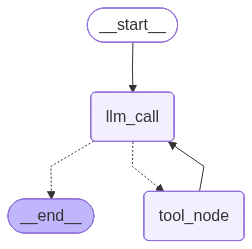

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_VlYFEHiziBLnmp89vePxIalr)
 Call ID: call_VlYFEHiziBLnmp89vePxIalr
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

3 plus 4 equals 7.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [19]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()